# <a id='toc1_'></a>[Training an ML model for Sentiment Analysis](#toc0_)

This notebook demonstrates applying a few-shot-learning approach to fine-tune a sentiment analysis model to perform sentiment classification on the product review dataset.

**Table of contents**<a id='toc0_'></a>    
- [Training an ML model for Sentiment Analysis](#toc1_)    
  - [Problem Definition](#toc1_1_)    
  - [Approach](#toc1_2_)    
  - [Data](#toc1_3_)    
  - [Training](#toc1_4_)    
  - [Inference](#toc1_5_)    
  - [Exporting](#toc1_6_)    
  - [Benefits](#toc1_7_)    
  - [Conclusion](#toc1_8_)    
  - [Future work](#toc1_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## <a id='toc1_1_'></a>[Problem Definition](#toc0_)
This tutorial tackles the following tasks:
* Choose a classification problem (Sentiment analysis, emotion detection, spam detection, topic classification of news articles)
* Develop a ML model that takes strings as inputs and predicts the corresponding label

## <a id='toc1_2_'></a>[Approach](#toc0_)
In this example we will train a transformer model, using a few-shot-learning pipeline, to predict the sentiment of the customer review.


## <a id='toc1_3_'></a>[Data](#toc0_)

As a demonstration of sentiment classification, we can use [SentEval-CR](https://huggingface.co/datasets/SetFit/SentEval-CR) dataset from huggingface. 
As described in the [original paper](https://dl.acm.org/doi/10.1145/1014052.1014073),  this dataset contains customer reviews in the e-commerce domain. 

The test split was created by randomly sampling 20% of the original data (753 samples), and the train split is the remaining 80% (3012 samples).

Upon investigating class balance, we can observe that positive reviews dominate with roughly a 2:1 ratio, equally spanning across test and train subsets.

In [1]:
from datasets import load_dataset, concatenate_datasets

In [2]:
DATASET_REPO = "SetFit"
DATASET_NAME = "SentEval-CR"

dataset = load_dataset(f"{DATASET_REPO}/{DATASET_NAME}", cache_dir=".dataset")


Repo card metadata block was not found. Setting CardData to empty.


In [3]:
# investigate class balance
print(dataset.filter(lambda x: x['label'] == 0)) # Negative
print(dataset.filter(lambda x: x['label'] == 1)) # Positive

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1079
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 286
    })
})
DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 1933
    })
    test: Dataset({
        features: ['text', 'label', 'label_text'],
        num_rows: 467
    })
})


## <a id='toc1_4_'></a>[Training](#toc0_)

The core training component is [SetFit](https://huggingface.co/blog/setfit). [paper](https://arxiv.org/abs/2209.11055), which heavily relies on:

* **Contrastive Learning**  is a deep learning technique for unsupervised representation learning. The goal is to learn a representation of data such that similar instances are close together in the representation space, while dissimilar instances are far apart. [[1]](https://paperswithcode.com/task/contrastive-learning)
* **Cosine Similarity Loss** for training the transformer encoder. It ensures that embeddings of the same class are close in a high-dimensional latent space, whereas embeddings for prototypes of different classes are apart.

For training, we can use pre-trained transformer models, such as [roBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment). It is trained on a very similar domain (classifying tweet sentiment), which ensures good performance with only a few samples.


In [4]:
from setfit import SetFitModel
from text_classification.classifier import Classifier

In [5]:
MODEL_REPO = "cardiffnlp"
MODEL_NAME = "twitter-roberta-base-sentiment"

PRE_TRAINED_MODEL_DIR = ".pre-trained-models"

In [6]:
model = SetFitModel.from_pretrained(f"{MODEL_REPO}/{MODEL_NAME}", cache_dir=PRE_TRAINED_MODEL_DIR)
model.model_body, model.model_head

No sentence-transformers model found with name .pre-trained-models/cardiffnlp_twitter-roberta-base-sentiment. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at .pre-trained-models/cardiffnlp_twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.


(SentenceTransformer(
   (0): Transformer({'max_seq_length': 514, 'do_lower_case': False}) with Transformer model: RobertaModel 
   (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
 ),
 LogisticRegression())

In [7]:
from matplotlib import pyplot as plt

In [8]:
# if running on CPU, comment this cell as it is only used to demonstrate how performance scales with the number of examples.

accuracy = []
SAMPLES_PER_CLASS_LIST = [1,2,4,8,16,32]

for SAMPLES_PER_CLASS in SAMPLES_PER_CLASS_LIST:

    sentiment_classifier = Classifier(model_name="sentence-transformers/paraphrase-mpnet-base-v2", cache_dir=PRE_TRAINED_MODEL_DIR)
    train_ds = concatenate_datasets([dataset['train'].shuffle(seed=42).filter(lambda x: x['label'] == label_id).select(range(SAMPLES_PER_CLASS)) for label_id in [0, 1]]).shuffle(seed=42)
    test_ds = dataset["test"]


    performance_metrics = sentiment_classifier.train(train_ds=train_ds, test_ds=test_ds, batch_size=64, num_iterations=20, num_epochs=2)
    accuracy.append(performance_metrics['accuracy'])

model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 80
  Num epochs = 2
  Total optimization steps = 4
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/2 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 160
  Num epochs = 2
  Total optimization steps = 6
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/3 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 320
  Num epochs = 2
  Total optimization steps = 10
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 640
  Num epochs = 2
  Total optimization steps = 20
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Iteration:   0%|          | 0/10 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 1280
  Num epochs = 2
  Total optimization steps = 40
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Iteration:   0%|          | 0/20 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 2560
  Num epochs = 2
  Total optimization steps = 80
  Total train batch size = 64


Epoch:   0%|          | 0/2 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Iteration:   0%|          | 0/40 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


Text(0.5, 1.0, 'Accuracy vs. Number of samples per class')

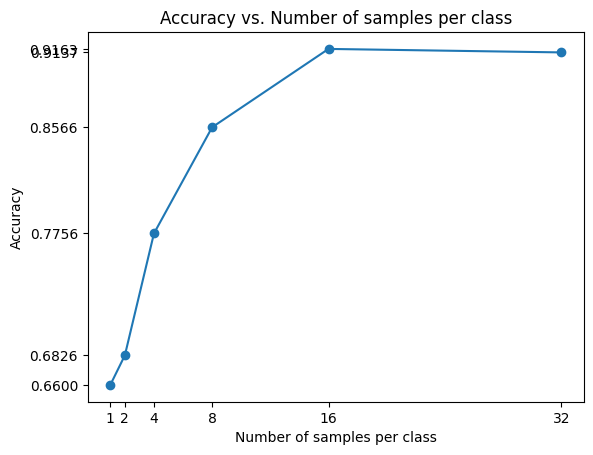

In [9]:
# plot the model
plt.plot(SAMPLES_PER_CLASS_LIST, accuracy, "-o")
plt.xticks(SAMPLES_PER_CLASS_LIST)
plt.yticks(accuracy)
plt.xlabel('Number of samples per class')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Number of samples per class')

In [10]:
SAMPLES_PER_CLASS = 4

sentiment_classifier = Classifier(model_name=f"{MODEL_REPO}/{MODEL_NAME}", cache_dir=PRE_TRAINED_MODEL_DIR)
train_ds = concatenate_datasets([dataset['train'].shuffle(seed=42).filter(lambda x: x['label'] == label_id).select(range(SAMPLES_PER_CLASS)) for label_id in [0, 1]]).shuffle(seed=42)
test_ds = dataset["test"]


performance_metrics = sentiment_classifier.train(train_ds=train_ds, test_ds=test_ds, batch_size=64, num_iterations=20, num_epochs=3)
performance_metrics

No sentence-transformers model found with name .pre-trained-models/cardiffnlp_twitter-roberta-base-sentiment. Creating a new one with MEAN pooling.
Some weights of RobertaModel were not initialized from the model checkpoint at .pre-trained-models/cardiffnlp_twitter-roberta-base-sentiment and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
model_head.pkl not found on HuggingFace Hub, initialising classification head with random weights. You should TRAIN this model on a downstream task to use it for predictions and inference.
Applying column mapping to training dataset


Generating Training Pairs:   0%|          | 0/20 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 320
  Num epochs = 3
  Total optimization steps = 15
  Total train batch size = 64


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/5 [00:00<?, ?it/s]

Applying column mapping to evaluation dataset
***** Running evaluation *****


{'accuracy': 0.8897742363877822}

## <a id='toc1_5_'></a>[Inference](#toc0_)

The following two snippets indicate how one can interact with a trained model and how high compute latency is. Using a single T4 GPU, this model can classify `>30 samples/sec`, making it suitable for deployment and real time applications

In [11]:
import numpy as np
from tqdm import tqdm

In [12]:
correct_count = 0
incorrect_count = 0
for ds_sample in tqdm(test_ds):
    text, y_true = ds_sample['text'], ds_sample['label']
    y_pred = np.argmax(sentiment_classifier.model.predict_proba([text]))

    if y_pred == y_true:
        correct_count += 1
    else:
        incorrect_count += 1

correct_count, incorrect_count

  0%|          | 3/753 [00:00<00:27, 26.90it/s]

100%|██████████| 753/753 [00:19<00:00, 38.76it/s]


(670, 83)

## <a id='toc1_6_'></a>[Exporting](#toc0_)

Final step is to save the trained model on disk, which will make it availabe for future use.

In [13]:
sentiment_classifier.export(f".trained-models/{MODEL_REPO}/{MODEL_NAME}/{DATASET_REPO}/{DATASET_NAME}")

## <a id='toc1_7_'></a>[Benefits](#toc0_)
There are multiple benefits to training a transformer-based classifier using SetFit.

* Few Shot Learning approach is essential for use cases which have an insufficient amount of data or where data labelling is an expensive task. Furthermore, an approach that quickly learns insights from a few examples is a good foundation for incremental improvement or active learning.

* Training a model using SetFit and FSL requires little compute infrastructure and can be completed quickly compared to traditional model training. As it shortens the development cycles, and increases response to data shifts, or the necessity to adapt the model to new tasks, SetFit is ideal for prototyping and R&D.
* images FSL approach does not work well only with text. As contrastive learning is a general concept, one can easily use [transformers for images](https://huggingface.co/sentence-transformers/clip-ViT-B-32).

## <a id='toc1_8_'></a>[Conclusion](#toc0_)

This tutorial covered how to train a transformer to classify a customer review based on sentiment. For this, we have leveraged a few-shot-learning approach [SetFit](https://huggingface.co/blog/setfit), a pre-trained [roBERTa](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment) model and a [customer review dataset](https://huggingface.co/datasets/SetFit/SentEval-CR). Using as few as 4 examples of each class, we are able to achieve an accuracy level of  ~ 0.9, with the training that is CPU friendly.

## <a id='toc1_9_'></a>[Future work](#toc0_)

Future work on this topic may consider deployment on edge devices. Topics which could raise interest are:
* Knowledge distillation - Train large models (teachers) and use them to transfer performance on smaller, more realtime-friendly models.
* Quantization - reducing the number of bits with which information is represented achieves a more compute-effective formats like INT8.
* Effective formats; ONNX graphs ensure that model inference is more optimal